In [2]:
## implement the MOGP with the heterotopic case

## Modeling in term of two functions which is quadratic function, convex
## D1 and D2 can be different all points different, some points can be overlap (in training)
## Testing data will totally differents

## 1. Load the Hessian from .mat file

## 2. Generate function

## 3. Generate data function for each functions and sharing training points

## 4. Construct the covariance structure between two functions (may just use the library for this)

## 5. Prepare data for training using two datasets.

## 6. Training the model + get results in test (RMSE + NLL) for predictions of each function

## 7. Train separate GP & compare the result with training separately model

## 8. Vary data -> see the different vary in the result


In [8]:
# !pip install gpytorch

In [61]:
import torch
import gpytorch
import numpy as np
import math

In [63]:
from scipy.io import loadmat

In [65]:
mat_file_path = r"C:\\Users\\longv\\research\\mogp\\data_quad\\data\\10 Agents\\p5\\Set1.mat"
mat_data = loadmat(mat_file_path)

In [67]:
# getting the hession matrix 
hessian_matrix = mat_data["Phi"][0]

In [69]:
torch.manual_seed(0); np.random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

In [71]:
#choose function
idx0, idx1 = 0, 3

# choose input range
x_range = (0, 0.5) ## the input range could be larger but due to the limitation of data -> try to keep it in small range

#training and testsizes

n_train_task = 10     # try small point first
n_test_task  = 100          # more test points per task
overlap_train = 0           # small overlap between tasks
overlap_test  = 0          # some overlap in test sets
obs_noise_std = 0.01        # observation noise sigma
lmc_rank = 2                # SLFM rank let just 1

In [73]:
A0 = torch.tensor(np.array(hessian_matrix[idx0], dtype=np.float32), device=device)
A1 = torch.tensor(np.array(hessian_matrix[idx1], dtype=np.float32), device=device)

In [75]:
A0

tensor([[ 3.0527,  0.0051,  0.7544,  0.1052,  0.3904],
        [ 0.0051,  1.2829,  0.3123, -0.2400,  0.1624],
        [ 0.7544,  0.3123,  2.3509,  0.1673,  0.0201],
        [ 0.1052, -0.2400,  0.1673,  3.4453,  0.2774],
        [ 0.3904,  0.1624,  0.0201,  0.2774,  1.4418]], device='cuda:0')

In [77]:
A1

tensor([[ 2.3162,  0.4711,  0.3913,  0.0794,  0.1488],
        [ 0.4711,  2.3593, -0.0381,  0.9046,  0.0911],
        [ 0.3913, -0.0381,  3.2369,  0.3954,  0.3434],
        [ 0.0794,  0.9046,  0.3954,  2.8831, -0.7183],
        [ 0.1488,  0.0911,  0.3434, -0.7183,  1.6790]], device='cuda:0')

In [79]:
d = A0.shape[0]
d

5

In [81]:
#define the qad func

def f_quad(X, A):
    # X: (N, d) tensor
    # A: dxd tensor
    return torch.einsum('ni,ij,nj->n', X, A, X) ## x @ A @ x^T



In [83]:
## heterotopic data generate(with some train point overlap and some test point overlap)

def heterotopic_split(n_train_task, n_test_task, d, overlap_train, overlap_test, x_range, seed=1234):
    rng = np.random.default_rng(seed)
    lo, hi = x_range

    # share subsets
    Xtr_shared = rng.uniform(lo, hi, size=(overlap_train, d))
    Xte_shared = rng.uniform(lo, hi, size=(overlap_test, d))

    # uniques
    def uniq(n): return rng.uniform(lo, hi, size=(n, d))

    n_u_tr = max(0, n_train_task - overlap_train)
    n_u_te = max(0, n_test_task  - overlap_test)
    
    X0_tr = np.vstack([Xtr_shared, uniq(n_u_tr)])
    X1_tr = np.vstack([Xtr_shared, uniq(n_u_tr)])
    
    X0_te = np.vstack([Xte_shared, uniq(n_u_te)])
    X1_te = np.vstack([Xte_shared, uniq(n_u_te)])
    
    rng.shuffle(X0_tr); rng.shuffle(X1_tr); rng.shuffle(X0_te); rng.shuffle(X1_te)
    to_t = lambda Z: torch.tensor(Z, dtype=dtype, device=device)
    
    return [to_t(X0_tr), to_t(X1_tr)], [to_t(X0_te), to_t(X1_te)]

Xtr_list, Xte_list = heterotopic_split(
    n_train_task, n_test_task, d, overlap_train, overlap_test, x_range, seed=2025
)

In [85]:
# getting label for the train and test point for each function
with torch.no_grad():
    y0_tr = f_quad(Xtr_list[0], A0)
    y1_tr = f_quad(Xtr_list[1], A1)
    y0_te = f_quad(Xte_list[0], A0)
    y1_te = f_quad(Xte_list[1], A1)

In [87]:
# add noise for train

noise = lambda shape: obs_noise_std * torch.randn(shape, dtype=dtype, device=device)

y0_tr_n = y0_tr + noise(y0_tr.shape)
y1_tr_n = y1_tr + noise(y1_tr.shape)

In [89]:
len(y0_tr_n)

10

In [91]:
# stack data to construct data for trainin + labeling for each data that belong to which tasks

def to_long_format(x_list, y_list):
    X = torch.cat(x_list, dim = 0)
    y = torch.cat(y_list, dim = 0)
    tids = []
    
    for t, Xt in enumerate(x_list):
        tids.append(torch.full((Xt.size(0),), t, dtype=torch.long, device=device))

    return X, torch.cat(tids, dim=0), y

Xtr_long, tids_tr, ytr_long = to_long_format([Xtr_list[0], Xtr_list[1]], [y0_tr_n, y1_tr_n])

In [93]:
#define the SLFM model with lowrank the rank is 1
from gpytorch.constraints import Interval

class ExactLMC_MOGP(gpytorch.models.ExactGP):
    def __init__(self, Xtrain, tids_train, ytrain, num_tasks=2, Q=2, ranks=None):
        lik = gpytorch.likelihoods.GaussianLikelihood()
        super().__init__((Xtrain, tids_train), ytrain, lik)
        
        self.likelihood = lik #choose the likelihood is gaussian
        
        self.mean = gpytorch.means.ZeroMean() #zero mean func

        d = Xtrain.size(-1) # set ard legnth
        
        self.Q = Q ## number of latent function
        
        if ranks is None:
            ranks = [1]*Q  # SLFM will be use as rank-1 if the rank is not provided 

        # input kernels k_q(x,x')
        self.x_kernels = torch.nn.ModuleList([
            gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.RBFKernel(ard_num_dims=d)
                # gpytorch.kernels.RBFKernel() #not ARD
                
            ) for _ in range(Q)
        ])

        # task cov = Aq @ Aq^T
        self.task_kernels = torch.nn.ModuleList([
            gpytorch.kernels.IndexKernel(num_tasks=num_tasks, rank=ranks[q], var_constraint=None) ## kernel on index task
            for q in range(Q)
        ])

        # bounding the hyperparams
        for q in range(Q):
            self.x_kernels[q].base_kernel.register_constraint("raw_lengthscale", Interval(0.01, 2.0))
            self.x_kernels[q].register_constraint("raw_outputscale", Interval(1e-4, 10.0))
            self.task_kernels[q].register_constraint("raw_var", Interval(1e-6, 10.0))

    def forward(self, X, task_ids):
        mean = self.mean(X)
        K = None
        for q in range(self.Q):
            Kq = self.x_kernels[q](X).mul(self.task_kernels[q](task_ids)) ## hadamaard product between the covariance and extended
            ## the output correlation matrix B
            ## K = Sum of q [K11 K12]
            ##              [K21 K22]   (N1+N2) x (N1 + N2)
            K = Kq if K is None else K + Kq
        return gpytorch.distributions.MultivariateNormal(mean, K)

Q = 2 ## the special case is they do not have anything to share -> the correlation matrix will give more weight to one latent 
## function than others

ranks = [1, 1] 

# define the model
model = ExactLMC_MOGP(Xtr_long, tids_tr, ytr_long, num_tasks=2, Q=Q, ranks=ranks).to(device)

#switch modle to train mode
model.train(); model.likelihood.train()

#select optimizer and lr & objective
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

In [95]:
for it in range(3000):
    optimizer.zero_grad() #clear state gradient
    with gpytorch.settings.cholesky_jitter(1e-4): # add small jitter to make sure the kernel matrix will always PSD
        out = model(Xtr_long, tids_tr) #forward passs
        loss = -mll(out, ytr_long) # eval the neg log marginal likelihood
    loss.backward() #backward pass
    optimizer.step() #update params
    if (it+1) % 100 == 0:
        print(f"[LMC model] -  iter {it+1:3d} - nll={loss.item():.4f} - noise={model.likelihood.noise.item():.4f}")


[LMC model] -  iter 100 - nll=1.1767 - noise=0.2917
[LMC model] -  iter 200 - nll=0.8304 - noise=0.1071
[LMC model] -  iter 300 - nll=0.5625 - noise=0.0436
[LMC model] -  iter 400 - nll=0.4218 - noise=0.0228
[LMC model] -  iter 500 - nll=0.3733 - noise=0.0161
[LMC model] -  iter 600 - nll=0.3530 - noise=0.0138
[LMC model] -  iter 700 - nll=0.2942 - noise=0.0112
[LMC model] -  iter 800 - nll=0.2594 - noise=0.0087
[LMC model] -  iter 900 - nll=0.2489 - noise=0.0077
[LMC model] -  iter 1000 - nll=0.2440 - noise=0.0073
[LMC model] -  iter 1100 - nll=0.2412 - noise=0.0072
[LMC model] -  iter 1200 - nll=0.2392 - noise=0.0072
[LMC model] -  iter 1300 - nll=0.2377 - noise=0.0072
[LMC model] -  iter 1400 - nll=0.2366 - noise=0.0072
[LMC model] -  iter 1500 - nll=0.2357 - noise=0.0073
[LMC model] -  iter 1600 - nll=0.2350 - noise=0.0073
[LMC model] -  iter 1700 - nll=0.2343 - noise=0.0073
[LMC model] -  iter 1800 - nll=0.2338 - noise=0.0073
[LMC model] -  iter 1900 - nll=0.2334 - noise=0.0073
[L

In [103]:
def eval_task(model, X_star, task_id, y_true):
    model.eval(); model.likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.cholesky_jitter(1e-4):
        tids = torch.full((X_star.size(0),), task_id, dtype=torch.long, device=device)
        pred = model.likelihood(model(X_star, tids))
        mean = pred.mean
        rmse = torch.sqrt(torch.mean((mean - y_true)**2)).item()
        nll  = (-pred.log_prob(y_true)).item()
        return rmse, nll

rmse_joint_task0, nll_joint_task0 = eval_task(model, Xte_list[0], 0, y0_te)
rmse_joint_task1, nll_joint_task1 = eval_task(model, Xte_list[1], 1, y1_te)

# Q-component LMC

with torch.no_grad():
    tasks_vec = torch.tensor([0, 1], dtype=torch.long, device=device)

    # each B_q (2x2) from the IndexKernel of component q
    Bq_list = []
    for q, tk in enumerate(model.task_kernels):
        Bq = tk(tasks_vec).to_dense()   # torch (2,2)
        Bq_list.append(Bq)
        print(f"\nB_{q} (task coregionalization for component {q}):")
        print(Bq.cpu().numpy())


B_0 (task coregionalization for component 0):
[[23.016771 20.163303]
 [20.163303 17.667864]]

B_1 (task coregionalization for component 1):
[[0.415056  1.6791873]
 [1.6791873 7.178894 ]]


In [105]:
print("RMSE of task 1:", rmse_joint_task0)
print("RMSE of task 2:", rmse_joint_task1)


RMSE of task 1: 0.12057346850633621
RMSE of task 2: 0.14962968230247498


In [107]:
print("NLL of task 1:", nll_joint_task0)
print("NLL of task 2:", nll_joint_task1)


NLL of task 1: -147.83721923828125
NLL of task 2: -142.88616943359375


In [109]:
## SOGP

In [111]:
import torch, gpytorch
from gpytorch.constraints import Interval

# If you're in float32 now, double helps stability
X0tr, X1tr = Xtr_list[0].double(), Xtr_list[1].double()
X0te, X1te = Xte_list[0].double(), Xte_list[1].double()
y0tr = y0_tr.double(); y1tr = y1_tr.double()
y0te = y0_te.double(); y1te = y1_te.double()

In [113]:
try:
    y0tr_n = y0_tr_n.double()
    y1tr_n = y1_tr_n.double()
except NameError:
    sigma = float(obs_noise_std)
    y0tr_n = y0tr + sigma * torch.randn_like(y0tr)
    y1tr_n = y1tr + sigma * torch.randn_like(y1tr)

In [123]:
class ExactSingleGP(gpytorch.models.ExactGP):
    def __init__(self, Xtrain, ytrain):
        lik = gpytorch.likelihoods.GaussianLikelihood()
        super().__init__(Xtrain, ytrain, lik)
        self.mean_module  = gpytorch.means.ZeroMean()

        d = Xtrain.size(-1) #dim for using the ARD
        
        # One lengthscale for all 5 dims; outputscale on top.
        self.covar_module = gpytorch.kernels.ScaleKernel(
            # gpytorch.kernels.RBFKernel()  ##no ARD
            gpytorch.kernels.RBFKernel(ard_num_dims=d)  
        )

        self.likelihood = lik

        # sensible inits
        self.covar_module.base_kernel.lengthscale = 0.5 * torch.ones(
            1, d, dtype=torch.float64, device=Xtrain.device
        )
        self.covar_module.outputscale = torch.tensor(1.0, dtype=torch.float64, device=Xtrain.device)
        self.likelihood.noise = torch.tensor(max(1e-4, float(obs_noise_std)**2), dtype=torch.float64)

        # bounds
        
        self.covar_module.base_kernel.register_constraint("raw_lengthscale", Interval(0.01, 2.0))
        self.covar_module.register_constraint("raw_outputscale", Interval(1e-4, 10.0))
        self.likelihood.noise_covar.register_constraint("raw_noise", Interval(1e-6, 0.5))

    def forward(self, X):
        mean_x = self.mean_module(X)
        covar_x = self.covar_module(X)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [125]:
def train_sogp(Xtr, ytr, iters=3000, lr=0.01, jitter=1e-3):
    m = ExactSingleGP(Xtr, ytr).to(Xtr.device).double()
    m.train(); m.likelihood.train()
    opt = torch.optim.Adam(m.parameters(), lr=lr)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(m.likelihood, m)
    
    for it in range(iters):
        opt.zero_grad()
        with gpytorch.settings.cholesky_jitter(jitter):
            out = m(Xtr)
            loss = -mll(out, ytr)
        if not torch.isfinite(loss): 
            print(f"[SOGP] non-finite loss at iter {it}"); break
        loss.backward()
        torch.nn.utils.clip_grad_norm_(m.parameters(), 10.0)
        opt.step()
        if (it+1) % 100 == 0:
            print(f"[SOGP] iter {it+1:3d}  nll={loss.item():.4f}  noise={m.likelihood.noise.item():.4g}")
    m.eval(); m.likelihood.eval()
    return m

In [127]:
def eval_sogp(m, Xte, yte, jitter=1e-4):
    with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.cholesky_jitter(jitter):
        pred = m.likelihood(m(Xte))
        mean = pred.mean
        rmse = torch.sqrt(torch.mean((mean - yte)**2)).item()
        nll  = (-pred.log_prob(yte)).item()
    return rmse, nll

In [129]:
m0 = train_sogp(X0tr, y0tr_n)
m1 = train_sogp(X1tr, y1tr_n)

[SOGP] iter 100  nll=0.6473  noise=1e-06
[SOGP] iter 200  nll=0.6203  noise=1e-06
[SOGP] iter 300  nll=0.6109  noise=1e-06
[SOGP] iter 400  nll=0.6061  noise=1e-06
[SOGP] iter 500  nll=0.6031  noise=1e-06
[SOGP] iter 600  nll=0.6011  noise=1e-06
[SOGP] iter 700  nll=0.5997  noise=1e-06
[SOGP] iter 800  nll=0.5987  noise=1e-06
[SOGP] iter 900  nll=0.5979  noise=1e-06
[SOGP] iter 1000  nll=0.5974  noise=1e-06
[SOGP] iter 1100  nll=0.5969  noise=1e-06
[SOGP] iter 1200  nll=0.5965  noise=1e-06
[SOGP] iter 1300  nll=0.5962  noise=1e-06
[SOGP] iter 1400  nll=0.5960  noise=1e-06
[SOGP] iter 1500  nll=0.5958  noise=1e-06
[SOGP] iter 1600  nll=0.5956  noise=1e-06
[SOGP] iter 1700  nll=0.5955  noise=1e-06
[SOGP] iter 1800  nll=0.5953  noise=1e-06
[SOGP] iter 1900  nll=0.5952  noise=1e-06
[SOGP] iter 2000  nll=0.5951  noise=1e-06
[SOGP] iter 2100  nll=0.5950  noise=1e-06
[SOGP] iter 2200  nll=0.5950  noise=1e-06
[SOGP] iter 2300  nll=0.5949  noise=1e-06
[SOGP] iter 2400  nll=0.5948  noise=1e-06
[

In [131]:
rmse0, nll0 = eval_sogp(m0, X0te, y0te)
rmse1, nll1 = eval_sogp(m1, X1te, y1te)

print("\nSOGP results")
print(f"Task0: RMSE={rmse0:.4f}  NLL={nll0:.3f}")
print(f"Task1: RMSE={rmse1:.4f}  NLL={nll1:.3f}")


[SOGP results]
task0: RMSE=0.1972  NLL=-175.152
task1: RMSE=0.2145  NLL=-213.111


In [137]:
# summarize results:

rmse = {
    "task0": {"SOGP": rmse0, "MOGP": rmse_joint_task0},
    "task1": {"SOGP": rmse1, "MOGP": rmse_joint_task1},
}

nll  = {
    "task0": {"SOGP": nll0, "MOGP": nll_joint_task0},
    "task1": {"SOGP": nll1, "MOGP": nll_joint_task1},
}

In [155]:
def plot_metric(metric_dict, title, ylabel):
    tasks  = list(metric_dict.keys())
    x      = np.arange(len(tasks))
    width  = 0.30

    fig, ax = plt.subplots(figsize=(8,6))
    b1 = ax.bar(x - width/2, [metric_dict[t]["SOGP"] for t in tasks], width, label="SOGP")
    b2 = ax.bar(x + width/2, [metric_dict[t]["MOGP"] for t in tasks], width, label="MOGP")

    ax.set_xticks(x); ax.set_xticklabels(tasks)
    ax.set_ylabel(ylabel); ax.set_title(title)
    ax.legend()
    ax.grid(axis="y", linestyle="--", alpha=0.2)

    # geting the value laebl
    for b in list(b1)+list(b2):
        h = b.get_height()
        ax.annotate(f"{h:.3}", (b.get_x()+b.get_width()/2, h),
                    ha="center", va="bottom", textcoords="offset points", xytext=(0,3))
    plt.tight_layout()
    plt.show()

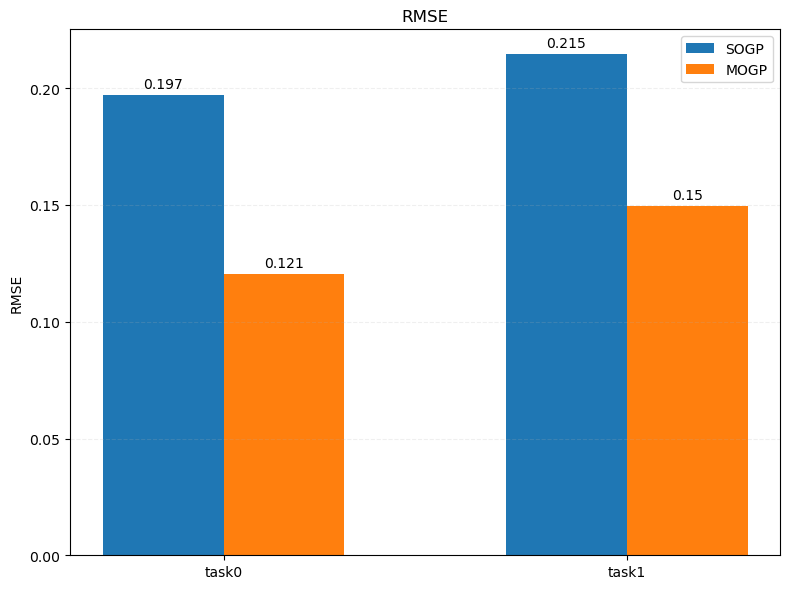

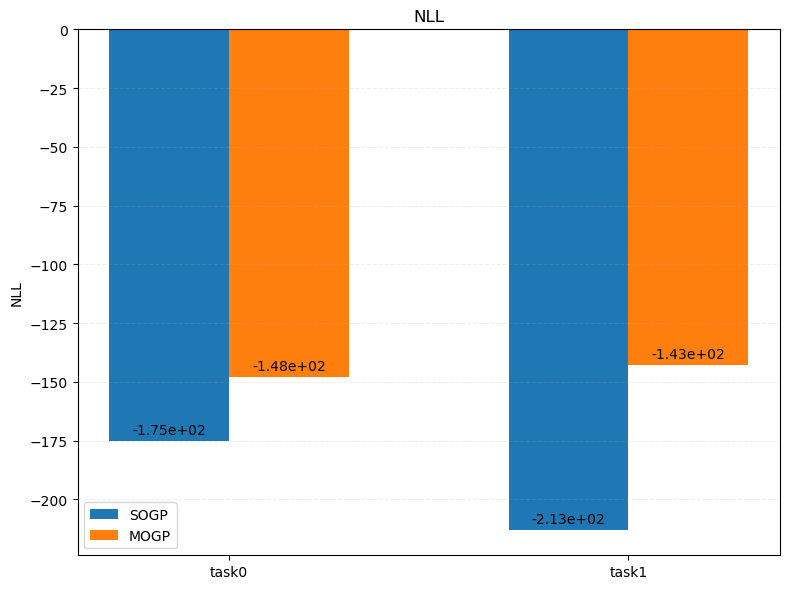

In [157]:
plot_metric(rmse, "RMSE", "RMSE")
plot_metric(nll, "NLL", "NLL")